In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tfl

from tensorflow import keras
from tensorflow.keras import layers

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [3]:
import xarray as xr
import os

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Temperature data 

In [4]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [5]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [6]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(temp.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  16. ,  24. ,  32. ,  40. ,  48. ,  56. ,  64. ,
        72. ,  80. ,  88. ,  96. , 104. , 109.5, 110. ], dtype=float32)

In [7]:
temp = temp.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [8]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)

In [9]:
temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True) 

In [8]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

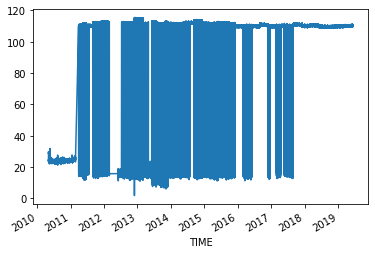

In [18]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
temp_df.PRES.plot()

In [39]:
# Max and min pressure values
bin_max = temp_df.PRES.max()
bin_min = temp_df.PRES.min()
bin_size = 2

In [40]:
def create_bins(bin_size, bin_max):
    """
    A function to return equal sized bins and corresponding bin labels for binning of data.
    Input:
    bin_size: size of bins
    bin_max: maximum value of the data to be binned. The minimum is assumed to be zero.
    """
    num_bins = np.ceil(bin_max/bin_size)
    lab_start = np.ceil(bin_size/2)
    bins = np.linspace(0, bin_size*num_bins, num_bins+1)
    labs = np.linspace(lab_start, bin_size*(num_bins-1)+lab_start, num_bins)
    return bins, labs

In [41]:
# Automatically calculate pressure bin parameters based on given bin_size
bins, labs = create_bins(bin_size, bin_max)

In [42]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs)

In [43]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [44]:
temp_df

TEMP
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  20.759911
3.0      2012-11-28 22:00:00  20.770100
7.0      2013-06-15 07:00:00  19.003767
         2013-06-15 08:00:00  18.982601
         2013-06-15 21:00:00  18.965900
...                                 ...
115.0    2014-11-06 22:00:00  15.896667
         2014-11-07 22:00:00  15.611667
         2014-11-07 23:00:00  15.620000
         2014-11-09 23:00:00  16.000000
         2014-11-10 00:00:00  16.036667

[149829 rows x 1 columns]

In [45]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
1.0,1
3.0,1
7.0,189
9.0,3047
11.0,3400
13.0,12072
15.0,33495
17.0,10984
19.0,1395


Based on nominal depths, it looks like most readings are from the 15, 24 and 110 dbar sensors.
So we will create bins around these depths as well.

In [10]:
bins = [0,11,19,20,28,106,114,116]
labs = [5.5,15,19.5,24,(106-28)/2,110,115]

In [11]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [12]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs, include_lowest=True)

In [13]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES']).dropna()

In [14]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
5.5,3919
15.0,38582
19.5,605
24.0,7391
39.0,68
110.0,65696
115.0,1891


Based on the binning above, three models will be trained: 15 dbar, 24 dbar and 110 dbar.

### 15 dbar

In [15]:
temp_df_15 = temp_df.xs(15)

In [16]:
temp_df_15

,TEMP
TIME,
2011-03-30 01:00:00,23.914965
2011-03-30 02:00:00,23.876726
2011-03-30 03:00:00,23.861305
2011-03-30 04:00:00,23.838934
2011-03-30 05:00:00,23.851543
...,...
2017-08-27 14:00:00,18.774223
2017-08-27 15:00:00,18.677221
2017-08-27 16:00:00,18.512810


In [16]:
temp_df_15.plot()

In [16]:
Time_diff = temp_df_15.index.to_series().diff()

(array([3.8523e+04, 3.0000e+01, 6.0000e+00, 7.0000e+00, 2.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.0000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30., 185.]),
 <a list of 31 Patch objects>)

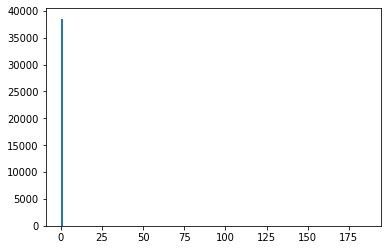

In [18]:
plt.hist((Time_diff/pd.Timedelta(days=1)), bins=np.append(np.linspace(0,30,31),185))#.where((Time_diff/pd.Timedelta(days=1)) > 1))

In [21]:
print('The longest gap in days is '+str((Time_diff/pd.Timedelta(days=1)).max())+' days (approx 6 months)')

The longest gap in days is 182.91666666666666 days (approx 6 months)


We will thus use the 6 month period before a gap and a 6 month period after a gap to predict a gap of 6 months using our RNN.

In [19]:
Time_diff.where(Time_diff > pd.Timedelta(days=7)).dropna()

TIME
2011-08-31 03:00:00    40 days 14:00:00
2012-05-31 01:00:00    92 days 00:00:00
2013-09-15 06:00:00     9 days 07:00:00
2014-09-11 01:00:00    45 days 17:00:00
2016-03-01 23:00:00    89 days 23:00:00
2016-11-30 23:00:00   182 days 22:00:00
2017-02-28 00:00:00    67 days 22:00:00
2017-05-26 01:00:00    40 days 19:00:00
Name: TIME, dtype: timedelta64[ns]

In [23]:
Time_diff.where(Time_diff > pd.Timedelta(hours=1)).min()

Timedelta('0 days 02:00:00')

If the 6 monthly model is too inaccurate, we can train a (92 day) 3 monthly model which will result in only a single gap of 182 days in the data.

#### Data generator

In [18]:
## find all locations where timeseries has gaps
temp_df_15.iloc[np.where(Time_diff > pd.Timedelta(hours=1))[0]]

,TEMP
TIME,
2011-04-08 16:00:00,24.550600
2011-04-09 15:00:00,25.100657
2011-05-21 04:00:00,20.977367
2011-05-22 04:00:00,21.429600
2011-07-04 07:00:00,20.654633
...,...
2017-04-14 18:00:00,22.955465
2017-04-14 20:00:00,22.947350
2017-04-14 22:00:00,22.880543


In [17]:
hist_len = 14*24
targ_len = 1

break_index = np.where(Time_diff > pd.Timedelta(hours=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15))
window_len = hist_len + targ_len

In [18]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(hours=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [19]:
data.shape, labels.shape

((25395, 336, 1), (25395, 1))

In [20]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)

In [21]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [22]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

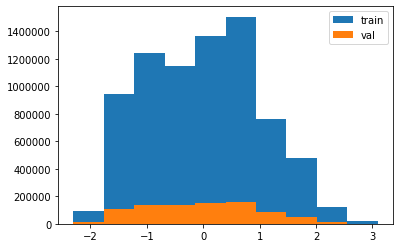

In [23]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

#### Model

In [25]:
import tensorflow as tfl

In [24]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

train_univariate = tfl.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tfl.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [34]:
simple_lstm_model = tfl.keras.models.Sequential([
    tfl.keras.layers.LSTM(64, input_shape=train_data.shape[-2:]),
    tfl.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mse', keras.metrics.MeanAbsolutePercentageError()])

In [25]:
bi_lstm_model = tfl.keras.models.Sequential()
bi_lstm_model.add(layers.Bidirectional(layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=train_data.shape[-2:])))
bi_lstm_model.add(layers.Bidirectional(layers.LSTM(16, activation='relu')))
bi_lstm_model.add(layers.Dense(1))

bi_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mse', keras.metrics.MeanAbsolutePercentageError()])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
bi_lstm_model.load_weights('../data/bi_lstm_training/cp.ckpt')

In [29]:
checkpoint_path = "../data/bi_lstm_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tfl.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [31]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 10

history = bi_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS,
                 callbacks=[cp_callback])

Epoch 1/10
177/178 [============================>.] - ETA: 1s - loss: 0.0942 - mean_squared_error: 0.0293 - mean_absolute_percentage_error: 74.3006
Epoch 00001: saving model to ../data/bi_lstm_training/cp.ckpt
178/178 [==============================] - 311s 2s/step - loss: 0.0942 - mean_squared_error: 0.0292 - mean_absolute_percentage_error: 104.0024 - val_loss: 0.0952 - val_mean_squared_error: 0.0297 - val_mean_absolute_percentage_error: 61.4463
Epoch 2/10
177/178 [============================>.] - ETA: 1s - loss: 0.0941 - mean_squared_error: 0.0292 - mean_absolute_percentage_error: 76.4515
Epoch 00002: saving model to ../data/bi_lstm_training/cp.ckpt
178/178 [==============================] - 308s 2s/step - loss: 0.0940 - mean_squared_error: 0.0291 - mean_absolute_percentage_error: 76.1902 - val_loss: 0.0979 - val_mean_squared_error: 0.0297 - val_mean_absolute_percentage_error: 62.7333
Epoch 3/10
177/178 [============================>.] - ETA: 1s - loss: 0.0949 - mean_squared_error: 

In [33]:
## Save model
bi_lstm_model.save('../data/saved_models/temp_gapfilling_bi_lstm_model.h5')

In [38]:
## Save History
import pickle
pickle_out = open("../data/bi_lstm_model_history.pickle", "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

#### Simple LSTM model

In [38]:
print(simple_lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
checkpoint_path = "../data/simple_lstm_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tfl.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [40]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS,
                 callbacks=[cp_callback])

Epoch 1/10
177/178 [============================>.] - ETA: 0s - loss: 0.1677 - mean_squared_error: 0.0736 - mean_absolute_percentage_error: 108.7136
Epoch 00001: saving model to ../data/simple_lstm_training/cp.ckpt
178/178 [==============================] - 126s 708ms/step - loss: 0.1674 - mean_squared_error: 0.0734 - mean_absolute_percentage_error: 108.2616 - val_loss: 0.1250 - val_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 89.3345
Epoch 2/10
177/178 [============================>.] - ETA: 0s - loss: 0.1230 - mean_squared_error: 0.0409 - mean_absolute_percentage_error: 95.1855
Epoch 00002: saving model to ../data/simple_lstm_training/cp.ckpt
178/178 [==============================] - 124s 698ms/step - loss: 0.1228 - mean_squared_error: 0.0407 - mean_absolute_percentage_error: 94.9862 - val_loss: 0.1144 - val_mean_squared_error: 0.0378 - val_mean_absolute_percentage_error: 84.0891
Epoch 3/10
177/178 [============================>.] - ETA: 0s - loss: 0.1094 - mean_

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
0,0.167445,0.073414,108.261566,0.125044,0.043113,89.334496,0
1,0.122845,0.040740,94.986160,0.114389,0.037751,84.089142,1
2,0.109395,0.034224,91.916466,0.107475,0.034064,80.454613,2
3,0.101742,0.031445,80.163765,0.098000,0.031036,77.203423,3
4,0.098580,0.030348,74.488716,0.093923,0.029912,72.762550,4
5,0.096305,0.029684,72.182892,0.092636,0.029777,72.311096,5
6,0.095276,0.029447,72.551208,0.094176,0.030293,74.336311,6
7,0.094712,0.029466,75.225677,0.092984,0.030123,71.968727,7
8,0.094203,0.029056,73.210197,0.092308,0.030119,71.616699,8
9,0.094748,0.029578,72.601456,0.093154,0.030545,72.403954,9


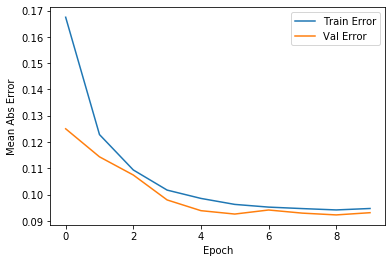

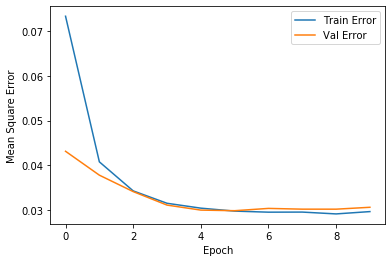

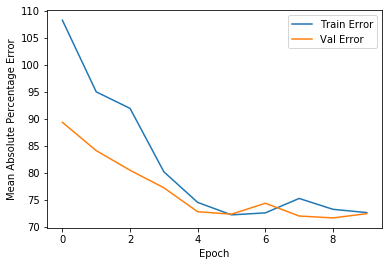

In [43]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [45]:
## Save model
simple_lstm_model.save('../data/saved_models/temp_gapfilling_simple_lstm_model.h5')

#### Multi-layer LSTM model

In [69]:
tfl.keras.backend.clear_session()

In [26]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tfl.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tfl.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [27]:
bilayer_lstm_model = tfl.keras.models.Sequential([
    tfl.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:]),
    tfl.keras.layers.LSTM(32, activation='relu'),
    tfl.keras.layers.Dense(1)
])

bilayer_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mse', keras.metrics.MeanAbsolutePercentageError()])

In [28]:
checkpoint_path = "../data/bilayer_lstm_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tfl.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [29]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 10

history = bilayer_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS,
                 callbacks=[cp_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
16/89 [====>.........................] - ETA: 1:57 - loss: nan - mean_squared_error: nan - mean_absolute_percentage_error: nan                                                  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-486a74c10381>", line 8, in <module>
    callbacks=[cp_callback])
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 780, in fit
    steps_name='steps_per_epoch')
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_arrays.py", line 274, in model_iteration
    batch_outs = f(actual_inputs)
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/keras/backend.py", line 3292, in __call__
    run_metadata=self.run_metadata)
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/

KeyboardInterrupt: 

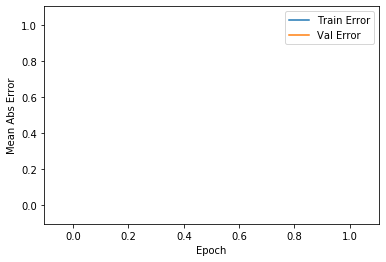

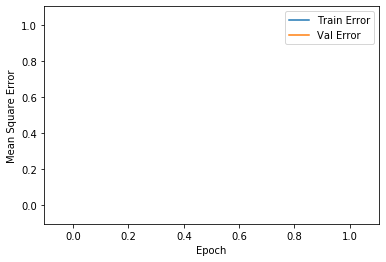

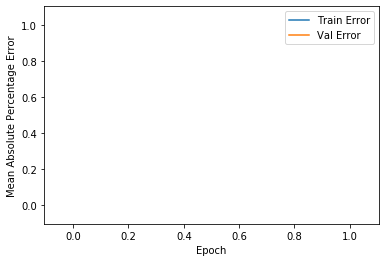

In [74]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)